# Predicting Heart Disease

## <b> Introduction <b>


According to the Center for Disease Control and Prevention, one person dies every 33 seconds from heart disease in the United States. Heart disease is a condition that affects the heart and blood vessels.Though there is no definite cure, it is possible to alleviate symptoms and prevent the condition from worsening and becoming fatal via lifestyle changes and medications. The question we will be answering is: How well can we predict the severity of heart disease in a patient based on health measurements taken in the hospital? We will be using the “Heart Disease'' dataset from the UC Irvine Machine Learning Repository which provides health and lifestyle characteristics of patients, and whether the patient is diagnosed with heart disease as well as its severity, ranging from 0 (no presence) to 4. 

**<b>Predictive Question<b>** : How well can we predict the severity of heart disease in a patient based on health measurements taken in the hospital?

**<b>Dataset<b>**: Heart Disease Dataset. It has 14 variables:

- Age: Years
- Sex : 1 = male , 0 = female
- cp :  chest pain type
- trestbps : resting blood pressure (mm Hg)
- chol :  serum cholesterol (mg/dl)
- fbs :   fasting blood sugar   ( 1: fbs >120mg/dl, 0 : fbx <120 mg/dl)
- Restecg : resting electrocardiographic results
- Thalach : maximum heart rate achieved
- exang :  exercise induced angina 
- Oldpeak : ST depression induced by exercise relative to rest
- Slope : slope of the peak exercise ST segment ( 1: upsloping, 2: flat,  downsloping)
- ca :   number of major vessels (0-3) colored by fluoroscopy
- Thal : normal, fixed defect, reversible defect
- Num :  Level of heart disease 

Other characteristics:
There is some missing data in the dataset. 


## <b>Preliminary Exploratory Data Analysis<b>

In [1]:
### Loading the relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library("RColorBrewer")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading the Data 

In [2]:
set.seed(1234)
#Reading the data from Github

#URl of the raw clevland.data file 
url <- "https://raw.githubusercontent.com/sachit-sharma/dsci-100-group-project-group53/main/processed.cleveland.data"
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_disease_data <- read_csv(url, col_names = column_names) |>
                       mutate (sex = as.factor(sex),
                               num = as.factor(num), 
                               across(cp:thal, as.numeric)) |>
                               rename(class = num)
#Changing all ? to NA
heart_disease_data[ heart_disease_data == "?"] <- NA 

#Removing all nas from numerical columns
heart_disease_data <- heart_disease_data |>
                      filter(!is.na(age), !is.na(thalach), !is.na(chol), !is.na(trestbps), !is.na(oldpeak), !is.na(slope))

head(heart_disease_data)

print("Table 1: Cleveland Heart Disease Dataset")

Rows: 626 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, ...
dbl  (4): age, sex, cp, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


[1] "Table 1: Cleveland Heart Disease Dataset"


We now split the data into seperate testing and training sets. We use 75% of our data for training and 25% for testing. We will keep the testing data aside for testing the accuracy of the model, and use the training data to train and tune the model.

In [3]:
set.seed(1234)
#Splitting the data into training and testing
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = class)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

### Calculating the mean of our predictors

In [4]:
#Calculating the mean value of the predictors 

heart_disease_select <-  heart_disease_train |>
                         select(age, trestbps, chol, thalach, oldpeak)

mean_values <- heart_disease_select |>
               map_df(mean, na.rm = TRUE)

print("Table 2: Mean Value of Predictors")
mean_values


[1] "Table 2: Mean Value of Predictors"


age,trestbps,chol,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55.77867,131.0533,183.016,139.9813,1.070667


The mean value of the predictors we are using are:

- Age : 56.3
- Tresbps (Resting Blood Pressure) : 131 mm of Hg
- Serum Cholestrol :131.62 mg/dl
- Thalach (Maximum Heart Rate) : 136.7 bpm

### Calculating the Maximum and Minimum values of our predictors

In [5]:
#Calculating the max of the predictors 

max_obs <-  heart_disease_select |>
            map_df(max, na.rm = TRUE)


max_obs 
print("Table 3: Maximum Value of Predictors")

age,trestbps,chol,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,200,564,195,6.2


[1] "Table 3: Maximum Value of Predictors"


In [6]:
#Calculating the min of the predictors 
min_obs <- heart_disease_select |>
           map_df(min, na.rm = TRUE)

min_obs
print("Table 4: Minimum Value of Predictors")

age,trestbps,chol,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,0,0,60,-2.6


[1] "Table 4: Minimum Value of Predictors"


### Calculating Distribution of the Classes

In [7]:
#Calculating the distribution of classes 

class_pct <- heart_disease_train |> 
             group_by(class) |>
             summarize(percentage = n()*100/nrow(heart_disease_train))

class_pct 
print("Table 5:Distribution of the Class Values")

class,percentage
<fct>,<dbl>
0,37.333333
1,24.800000
2,17.866667
3,15.733333
4,4.266667


[1] "Table 5:Distribution of the Class Values"



It is clear that the class 0 (absence of disease)is in the majority in the data set. The next most observed class is the presence of the lowest level of heart disease. Heart disease of level  4 is the least common in our data set. If a majority classifier was used, then it would only have a 35.04% accuracy. Looking at the the imbalance in the data, upsampling would be an important step. Later in the discussion, we explain why upsampling was not performed.

### Preliminary Graphic Analysis

Most of our variables seem to be reasonable predictors that could have possible connections to heart disease, so we examined their distribution.

We focused on age, chol (serum cholesterol), blood pressure (trestbps), heart rate (thalach), and ST Depression (oldpeak) since they are continuous variables. We excluded exercise induced angina (exang), ca, fasting blood sugar, cp and Restecg because they have discrete possible values, which makes them unhelpful for prediction.  

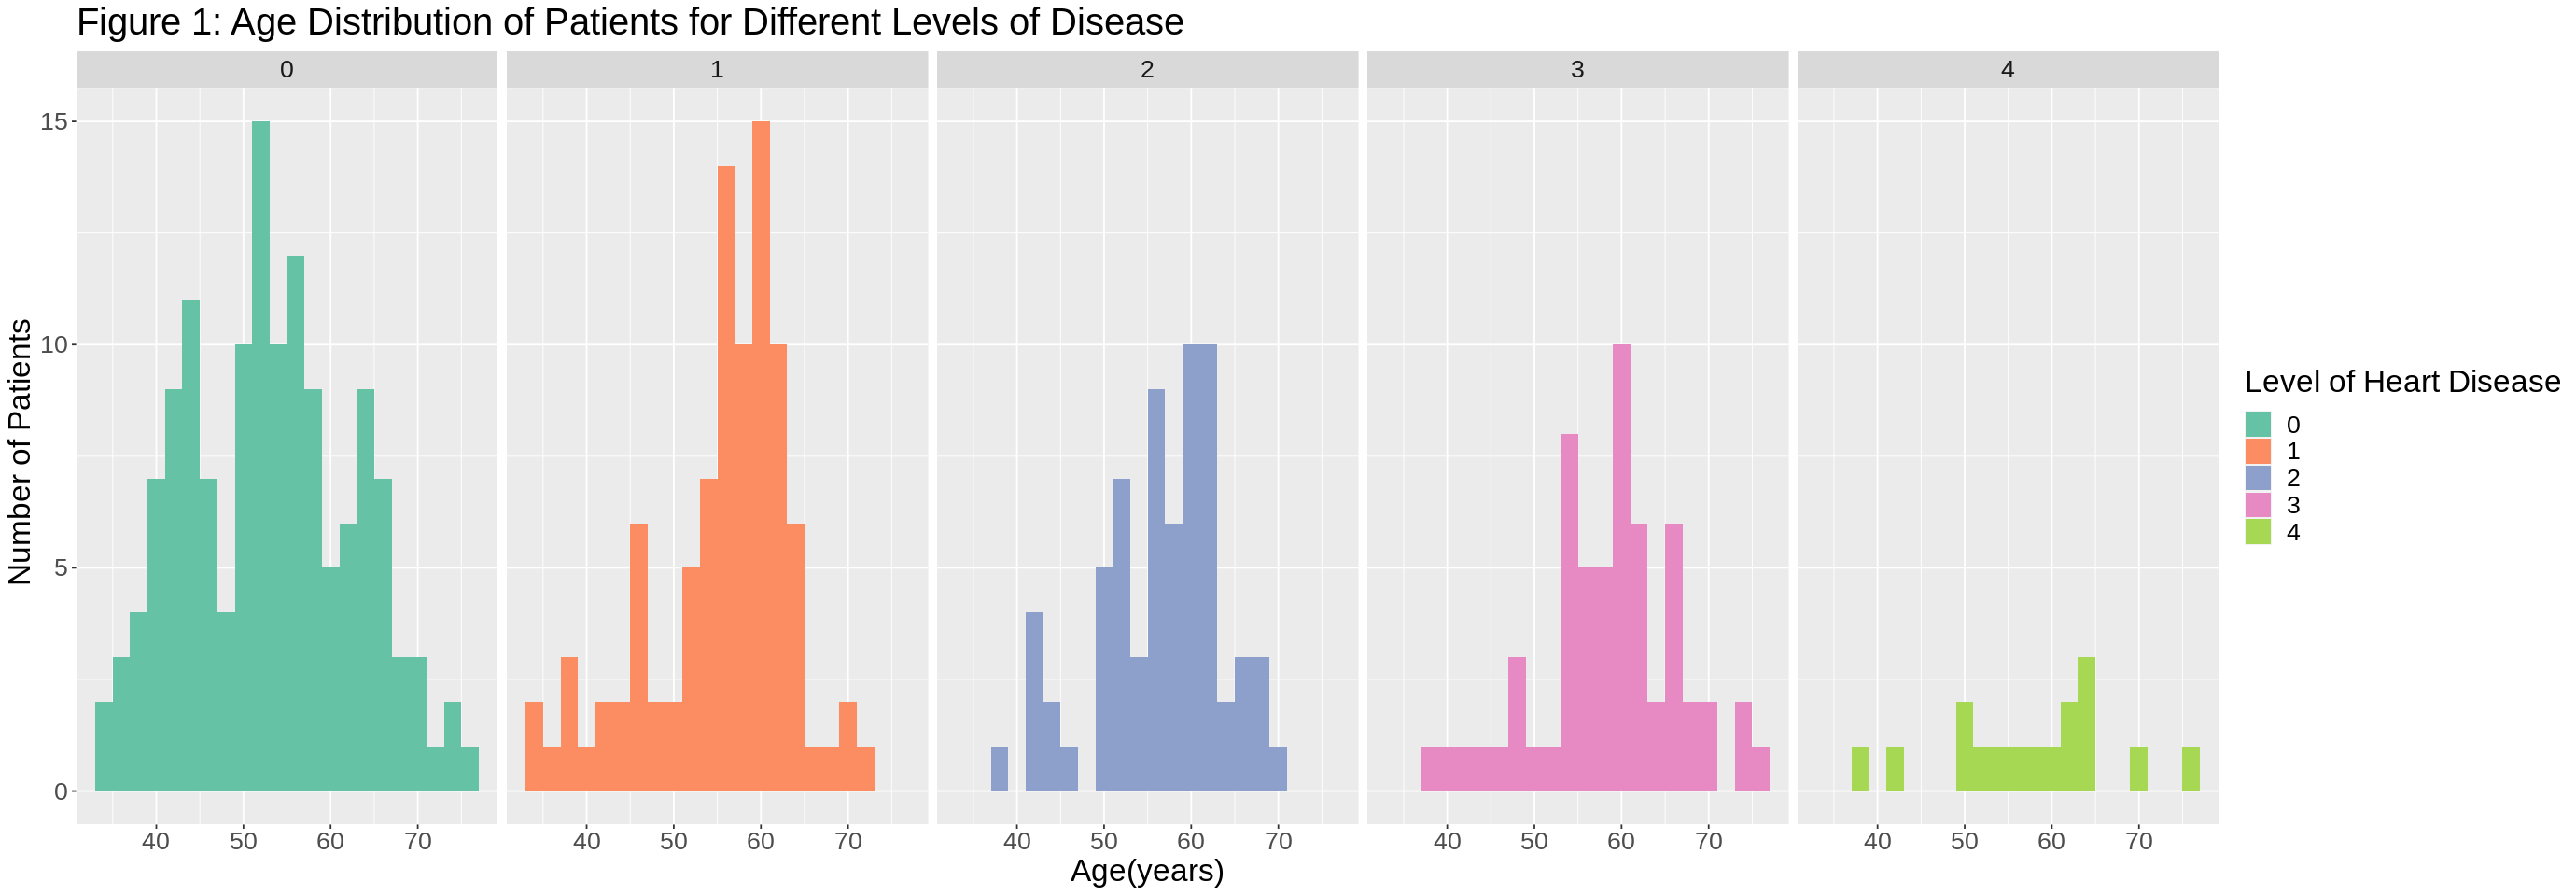

In [8]:
options(repr.plot.width = 23, repr.plot.height = 8)

age_hist <- ggplot(heart_disease_train,  aes(x = age, fill = class))  +
             geom_histogram(binwidth = 2) +
             labs(x = "Age(years)",  y = " Number of Patients", fill = "Level of Heart Disease") +
             facet_grid(cols = vars(class)) +
             scale_fill_brewer(palette = "Set2") +
             ggtitle("Figure 1: Age Distribution of Patients for Different Levels of Disease" ) +
             theme(text = element_text(size = 20)) 
age_hist


The mean age of people with no heart disease is around 50-55 years and for higher levels of heart disease, the mean age is greater than 60. We can also see that in the case of level 4 (the highest level of heart disease), there are no patients below the age of 40.  This suggests that age may be a good predictor for level of heart disease. 

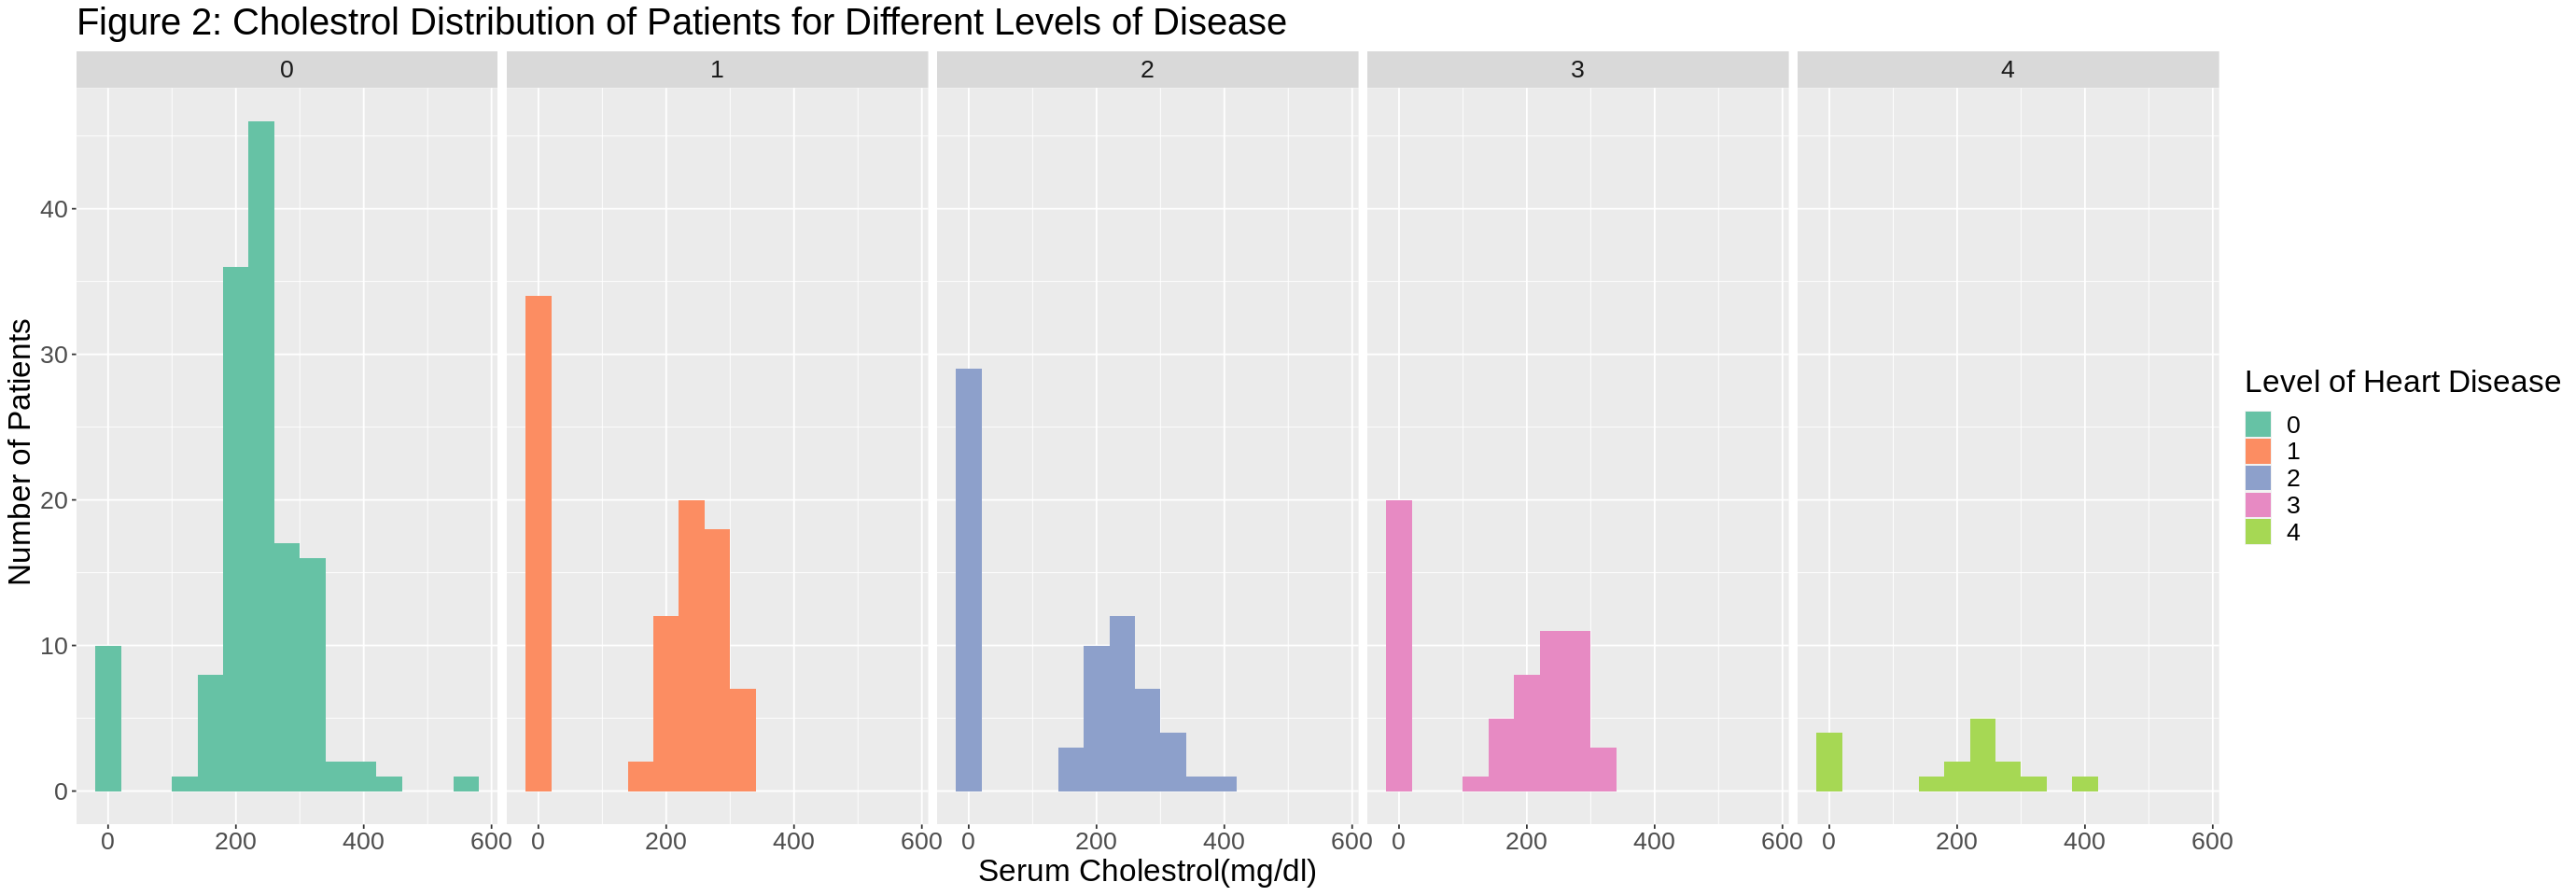

In [9]:
options(repr.plot.width = 23, repr.plot.height = 8)
chol_hist <- ggplot(heart_disease_train, aes(x = chol, fill = class)) + 
             geom_histogram(binwidth = 40) +
             labs(x = "Serum Cholestrol(mg/dl)", 
                  y = " Number of Patients", 
                  fill = "Level of Heart Disease") +
             ggtitle("Figure 2: Cholestrol Distribution of Patients for Different Levels of Disease" ) +
            scale_fill_brewer(palette = "Set2") +
             facet_grid(cols = vars(class)) +
             theme(text = element_text(size = 20))
chol_hist

The cholestrol distribution in the figure above shows that for people with no heart disease, the mean cholestrol is close to 200. Barring the strange peak of the distibution at 0 (which suggests the cholestrol data was not available), the mean of the cholestrol distribution shifts slightly rightward to around 250-300 for people with heart disease. This suggests cholestrol can be used as a predictor for heart.

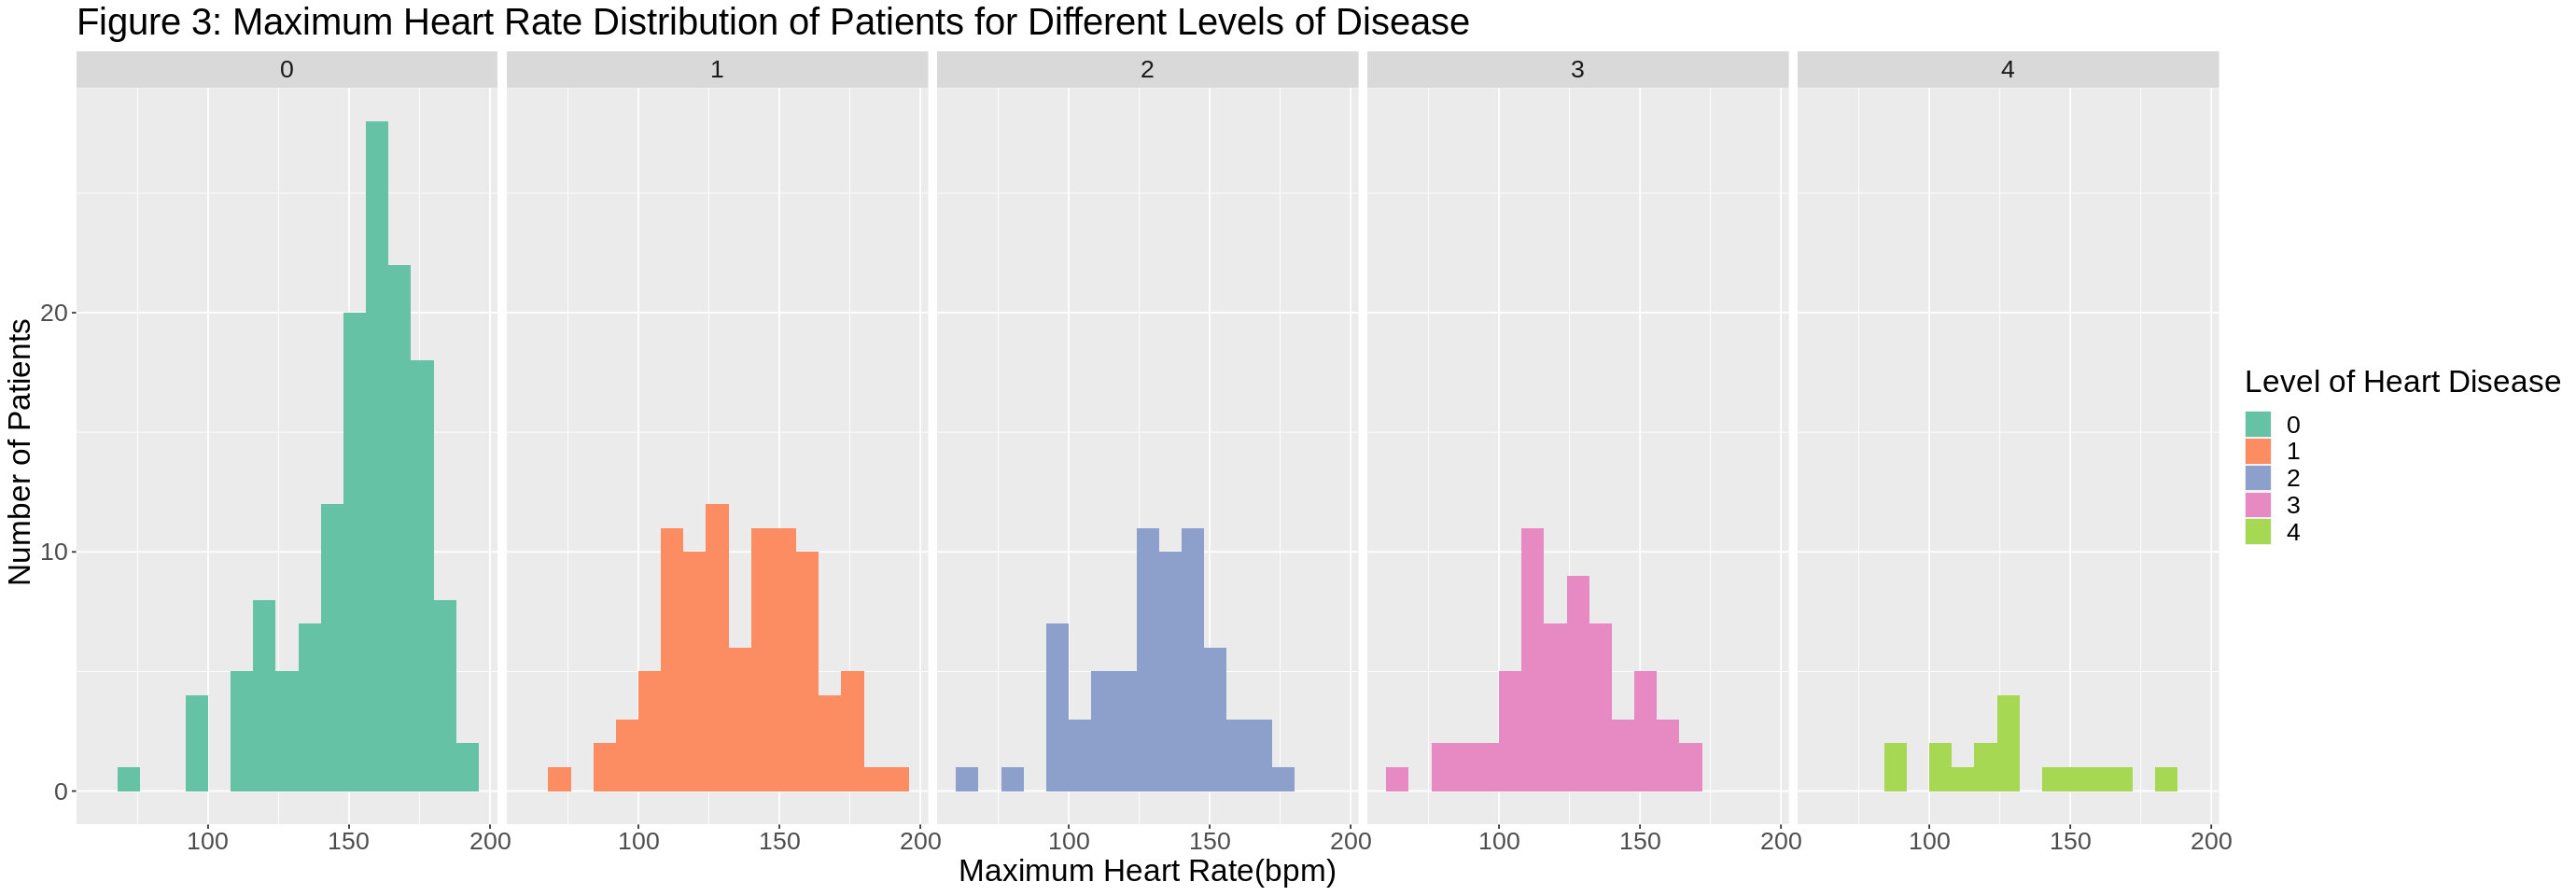

In [10]:
options(repr.plot.width = 23, repr.plot.height = 8)
thalach_hist <- ggplot(heart_disease_train,  aes(x = thalach, fill = class))  +
               geom_histogram(binwidth = 8) +
               labs(x = "Maximum Heart Rate(bpm)",  y = " Number of Patients", fill = "Level of Heart Disease") +
               facet_grid(cols = vars(class)) +
               scale_fill_brewer(palette = "Set2") +
               ggtitle("Figure 3: Maximum Heart Rate Distribution of Patients for Different Levels of Disease" ) +
             theme(text = element_text(size = 20)) 
thalach_hist

The heart rate distribution shows that the mean heart rate is around 130-150 for all levels of heart disease. The spread of the distribution also doesn't differ much by the level of disease, which makes it difficult to establish whether it is a good predictor.

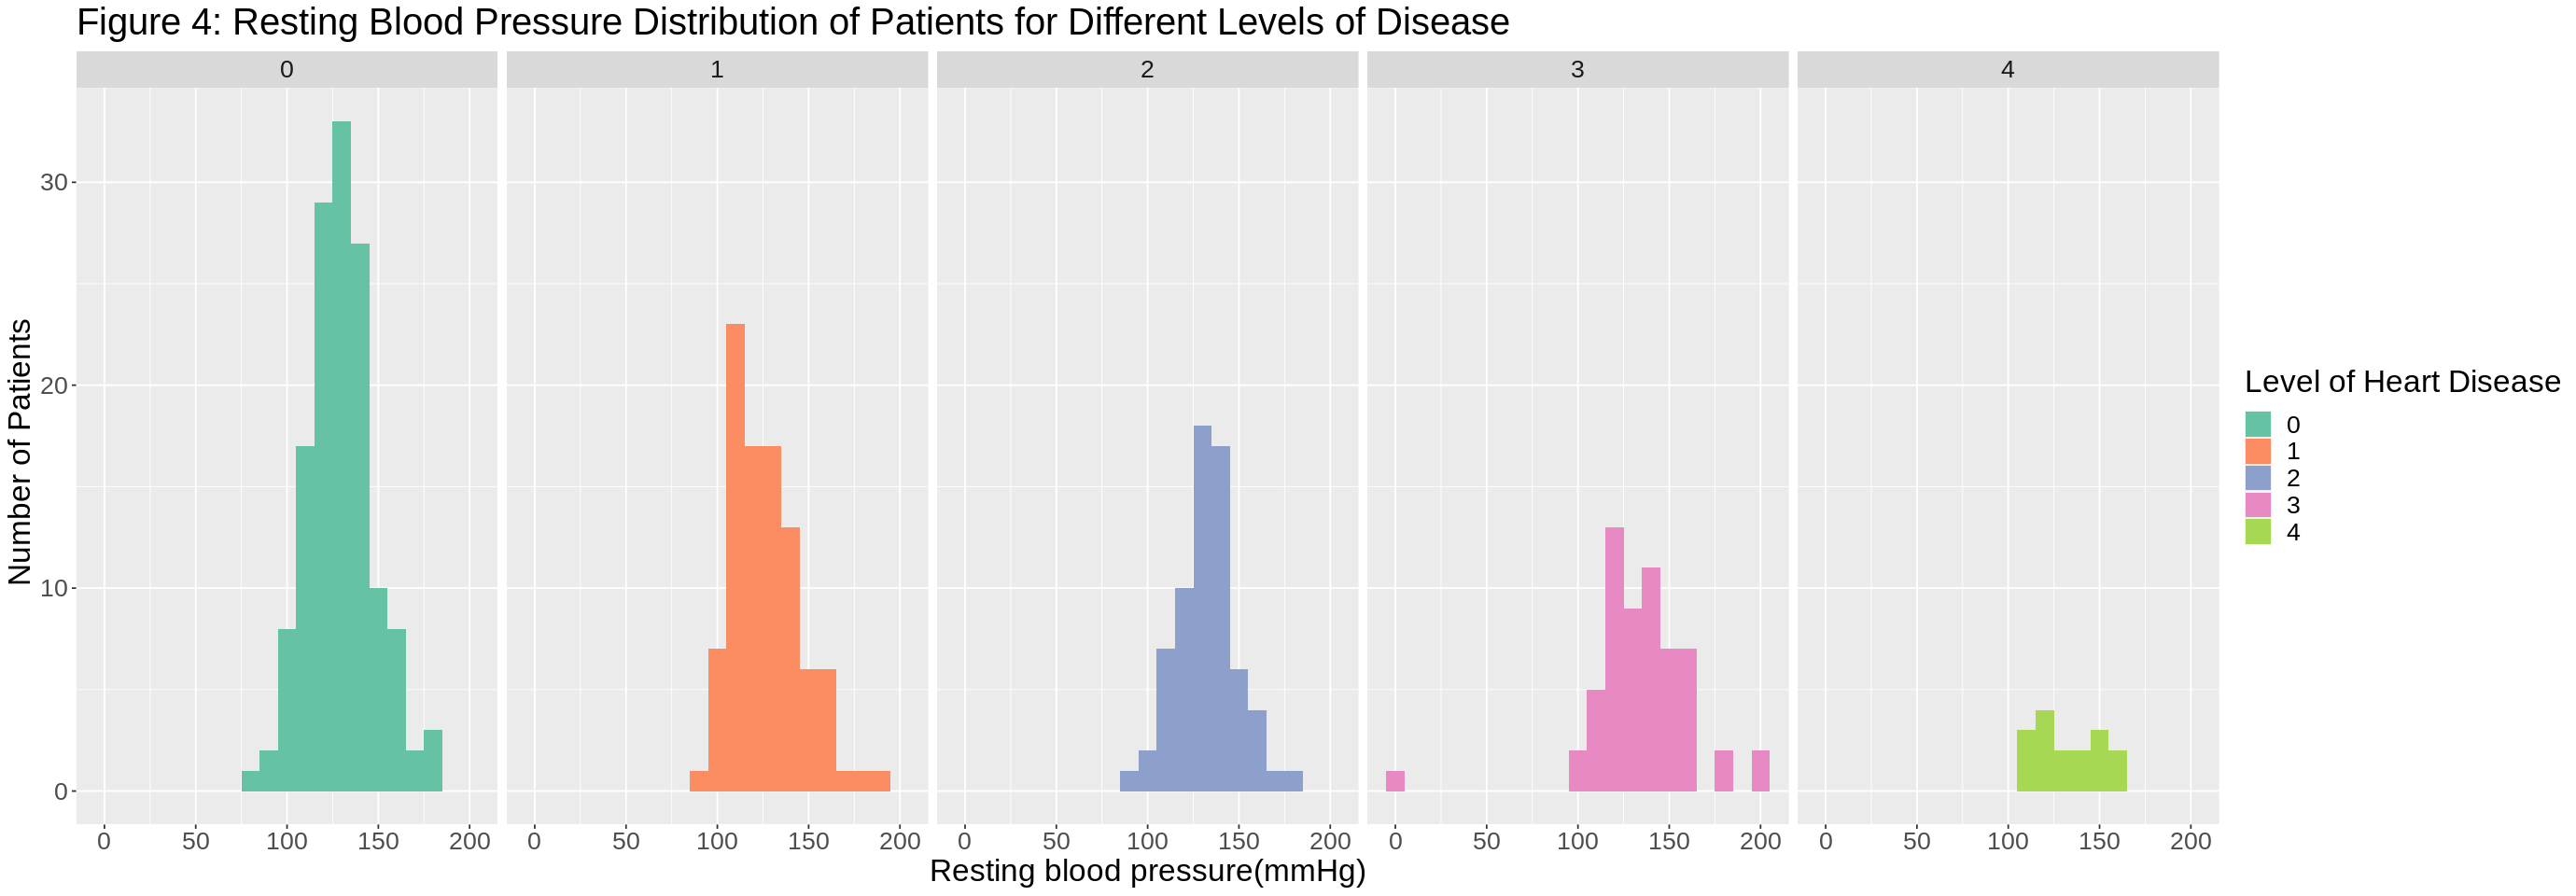

In [11]:
options(repr.plot.width = 23, repr.plot.height = 8)
bp_hist <- ggplot(heart_disease_train,  aes(x = trestbps, fill = class))  +
               geom_histogram(binwidth = 10) +
               labs(x = "Resting blood pressure(mmHg)",  y = " Number of Patients", fill = "Level of Heart Disease") +
               facet_grid(cols = vars(class)) +
               scale_fill_brewer(palette = "Set2") +
               ggtitle("Figure 4: Resting Blood Pressure Distribution of Patients for Different Levels of Disease" ) +
             theme(text = element_text(size = 20)) 
bp_hist

The blood pressure distribution shows that for all levels of heart disease, the mean blood pressure is around 120-140 mmHg. Since there does not seem to be much of a difference across all levels, we cannot say if it is a good predictor.

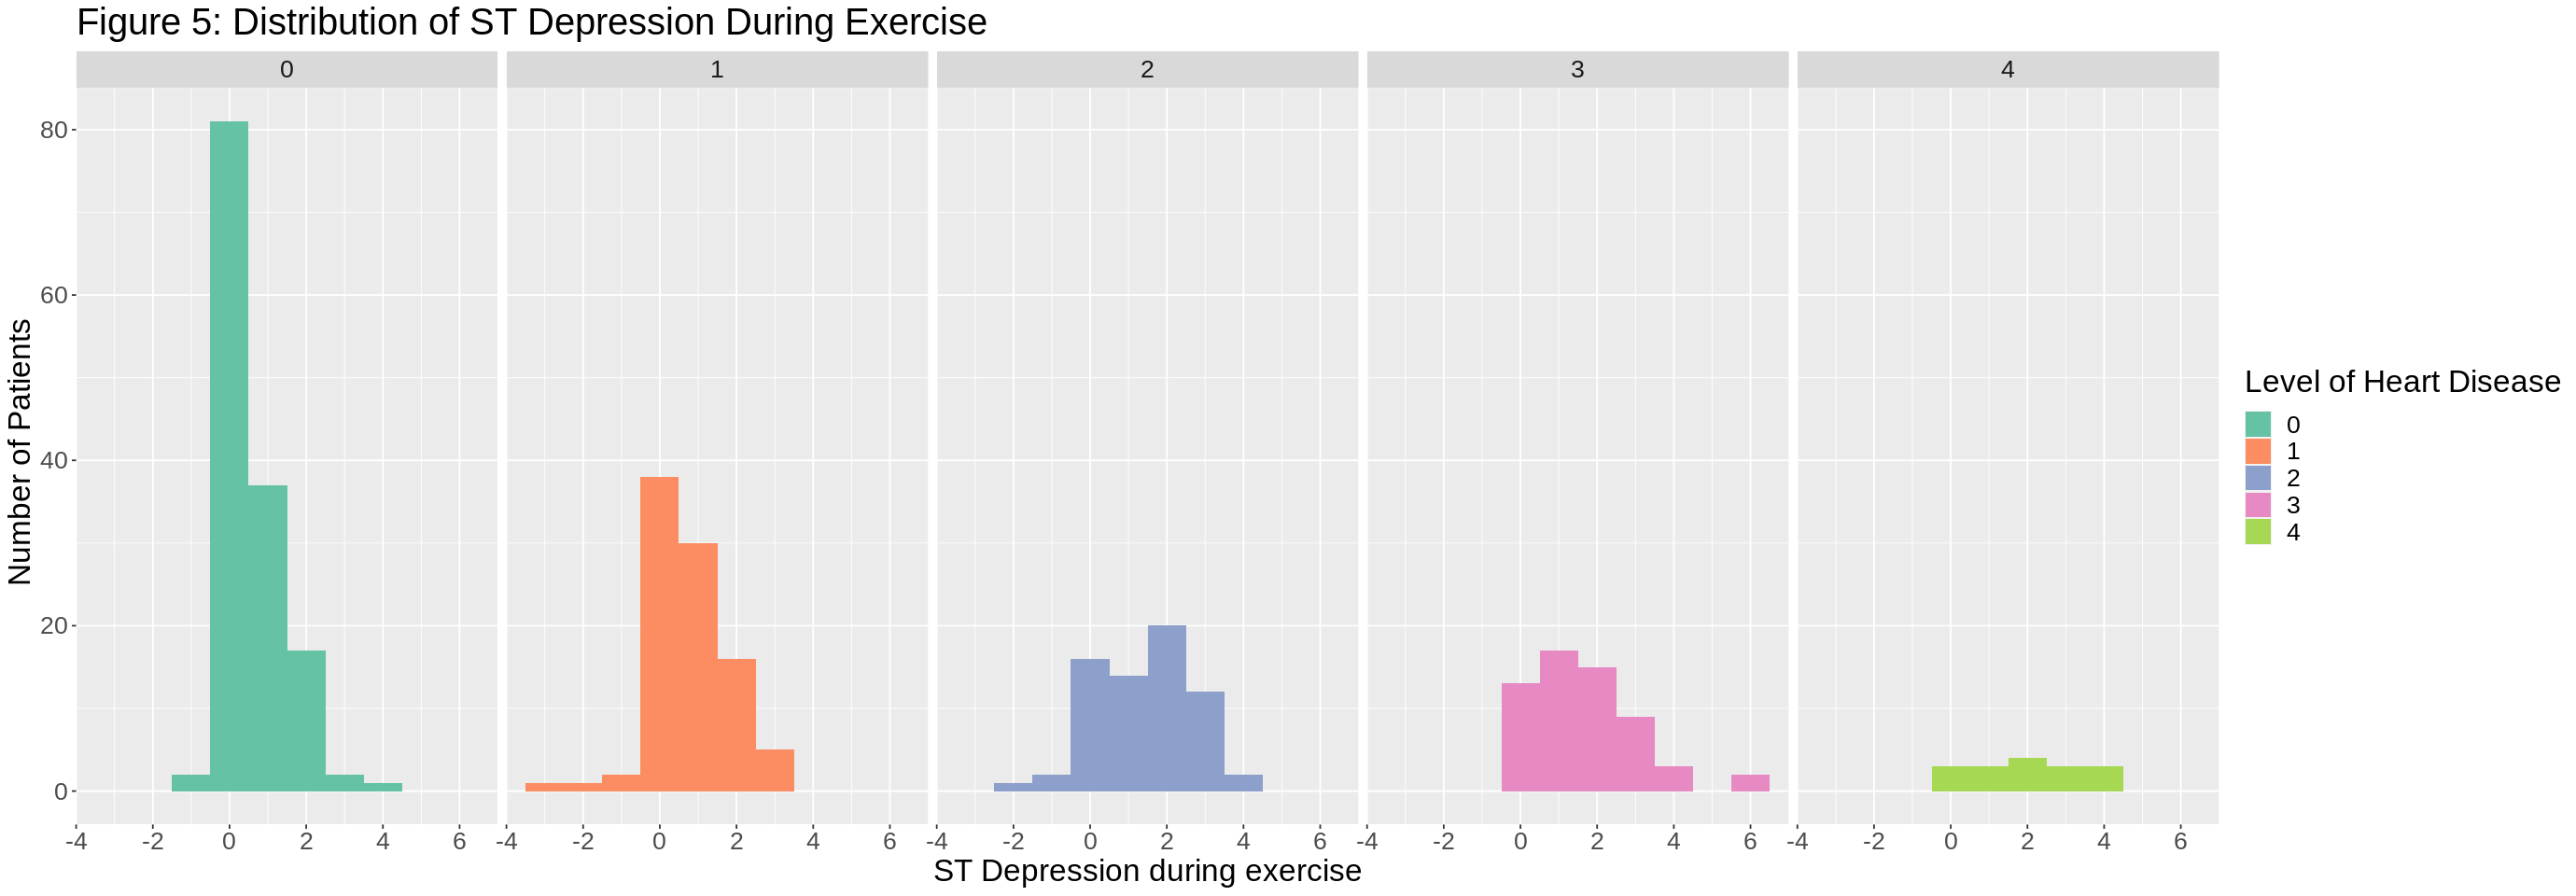

In [12]:
options(repr.plot.width = 23, repr.plot.height = 8)
old_peak_hist <- ggplot(heart_disease_train,  aes(x = oldpeak, fill = class))  +
               geom_histogram(binwidth = 1) +
               labs(x = "ST Depression during exercise",  y = " Number of Patients", fill = "Level of Heart Disease") +
               facet_grid(cols = vars(class)) +
               scale_fill_brewer(palette = "Set2") +
               ggtitle("Figure 5: Distribution of ST Depression During Exercise" ) +
             theme(text = element_text(size = 20)) 
old_peak_hist

The ST induced depression for patients with no heart disease is distributed from 0 to 4, with a peak at 0. However, the peak shifts to 1 or 2 for higher levels of heart disease. This could act as a good predictor, however, the correlation between heart disease and oldpeak is not that strong. 

### Results of exploratory analysis

From exploratory analysis, it seems that higher age, cholestrol and  ST depression correlate with higher heart disease.  We also know from our own knowledge that blood pressure and heart rate could be factors of heart disease. We thus chose age, cholestrol (chol), ST depression (oldpeak), blood pressure (trestbps), max heart rate (thalach) as our predictors. Later on, we use forward selection to determine the best combination of predictors. 

## <b>Methods<b>

We began our exploration by performing some exploratory analyses and determined a good set of initial predictors. According to relevant literature on the topic of heart disease, we found evidence supporting our choice of these predictors:

##### Reasons for choosing the predictors 
The predictors we initially started with are age, serum cholesterol (chol), maximum heart rate achieved (thalach), and resting blood pressure (trestpbps). We chose these because of a combination of scientific research and our own intuition of what contributes to heart disease. 

- **Age**: According to the American Heart Association (AHA), the incidence of heart disease in US mean and women is ~40% from 40-59 years, ~75% from 60-79 years and ~86% in those above the age of 80. This suggests that old age can be a significant factor towards predicting heart disease (Rodgers et al.,2019)

- **Cholestrol (chol)**: According to the study conducted by Jung et al.(2022), high serum cholesterol, which is composed of both high-density lipoprotein(HDL) and low-density lipoprotein(LDL), is shown to be associated with an increased mortality due to heart disease. As a result high cholestrol levels, can be a good predictor for high levels of heart disease. 

- **Maximum Heart Rate (thalach)** : A study by Peter-Guillaume et al.(2009)  found that high heart rate was a signifcant factor for cardiovasuclar disease. The study found that high heart rate was also associated with other risk factors for heart disease such as high blood pressure. As a result, we can expect high heart rate to be a predictor of high levels of heart disease. 

- **Resting Blood Pressure (trestpbs)** : Wu et al.(2015) found that stage 2-3 hypertension( blood presure >140 mm Hg) was associated with increased risk of cardiovascular disease and mortality among older adults. Thus, it can also serve as a good predictor. 

- **Exercise Induced ST Depression** - 

Selecting these 5 predictors, we will perform the classfication task of predicting the level of heart disease (from 0 to 4), using the K-nearest-neighbors algorithm. We will first perform cross validation and tune our model to determine the value of k. Thereafter, we will create a model using the best k value and test it on the testing data set. Finally, we will create a few visualiations and discuss our model's strengths and weaknesses:

- A plot of  “neighbors” vs “estimated accuracy”. This allows us to find the optimal k value which yields the best accuracy. 
- A confusion matrix to visualise where our model was right and where it was wrong
- A bar graph of accuracy of predicting various levels of heart disease


### Expected Outcomes and Significance

We expect to predict the severity of heart disease based on an individual’s physical health. We predict age, cholesterol levels, and resting blood pressure will be positively correlated to heart disease. Conversely, the maximum achievable heart rate will be negatively correlated with heart disease. These findings can help determine who may be at a higher risk of developing heart disease and prevent it. 

### Forward Selection

In addition to the literature previously discussed, we performed forward selection to determine which predictors would ensure the highest possible level of accuracy in our model. 

In [13]:
library(dplyr)
library(tidymodels)

set.seed(4321)

#Reference: https://datasciencebook.ca/classification2.html#forward-selection-in-r

#Creating the column names 
heart_disease_select <- heart_disease_train |>
                        select(age, chol, thalach, slope, oldpeak, trestbps, class)

names <- colnames(heart_disease_select |> select(-class))

#Create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

#Create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

#Create a 5-fold cross-validation object
heart_disease_vfold <- vfold_cv(heart_disease_select, v = 5, strata = class)

#Store the total number of predictors
n_total <- length(names)

#Stores selected predictors
selected <- c()

#For every size from 1 to the total number of predictors
for (i in 1:n_total) {
  #for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
          # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

           #create a recipe from the model string
    heart_disease_recipe <- recipe(as.formula(model_string), 
                                   data = heart_disease_select) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

            # tune the KNN classifier with these predictors, 
            # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_disease_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_disease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

            # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

print("Table 6: Accuracy Levels According to Number of Predictors")

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ trestbps,0.3921187
2,class ~ trestbps+thalach,0.4399168
3,class ~ trestbps+thalach+chol,0.4422591
4,class ~ trestbps+thalach+chol+slope,0.4718496
5,class ~ trestbps+thalach+chol+slope+age,0.4662620
6,class ~ trestbps+thalach+chol+slope+age+oldpeak,0.4501130


[1] "Table 6: Accuracy Levels According to Number of Predictors"


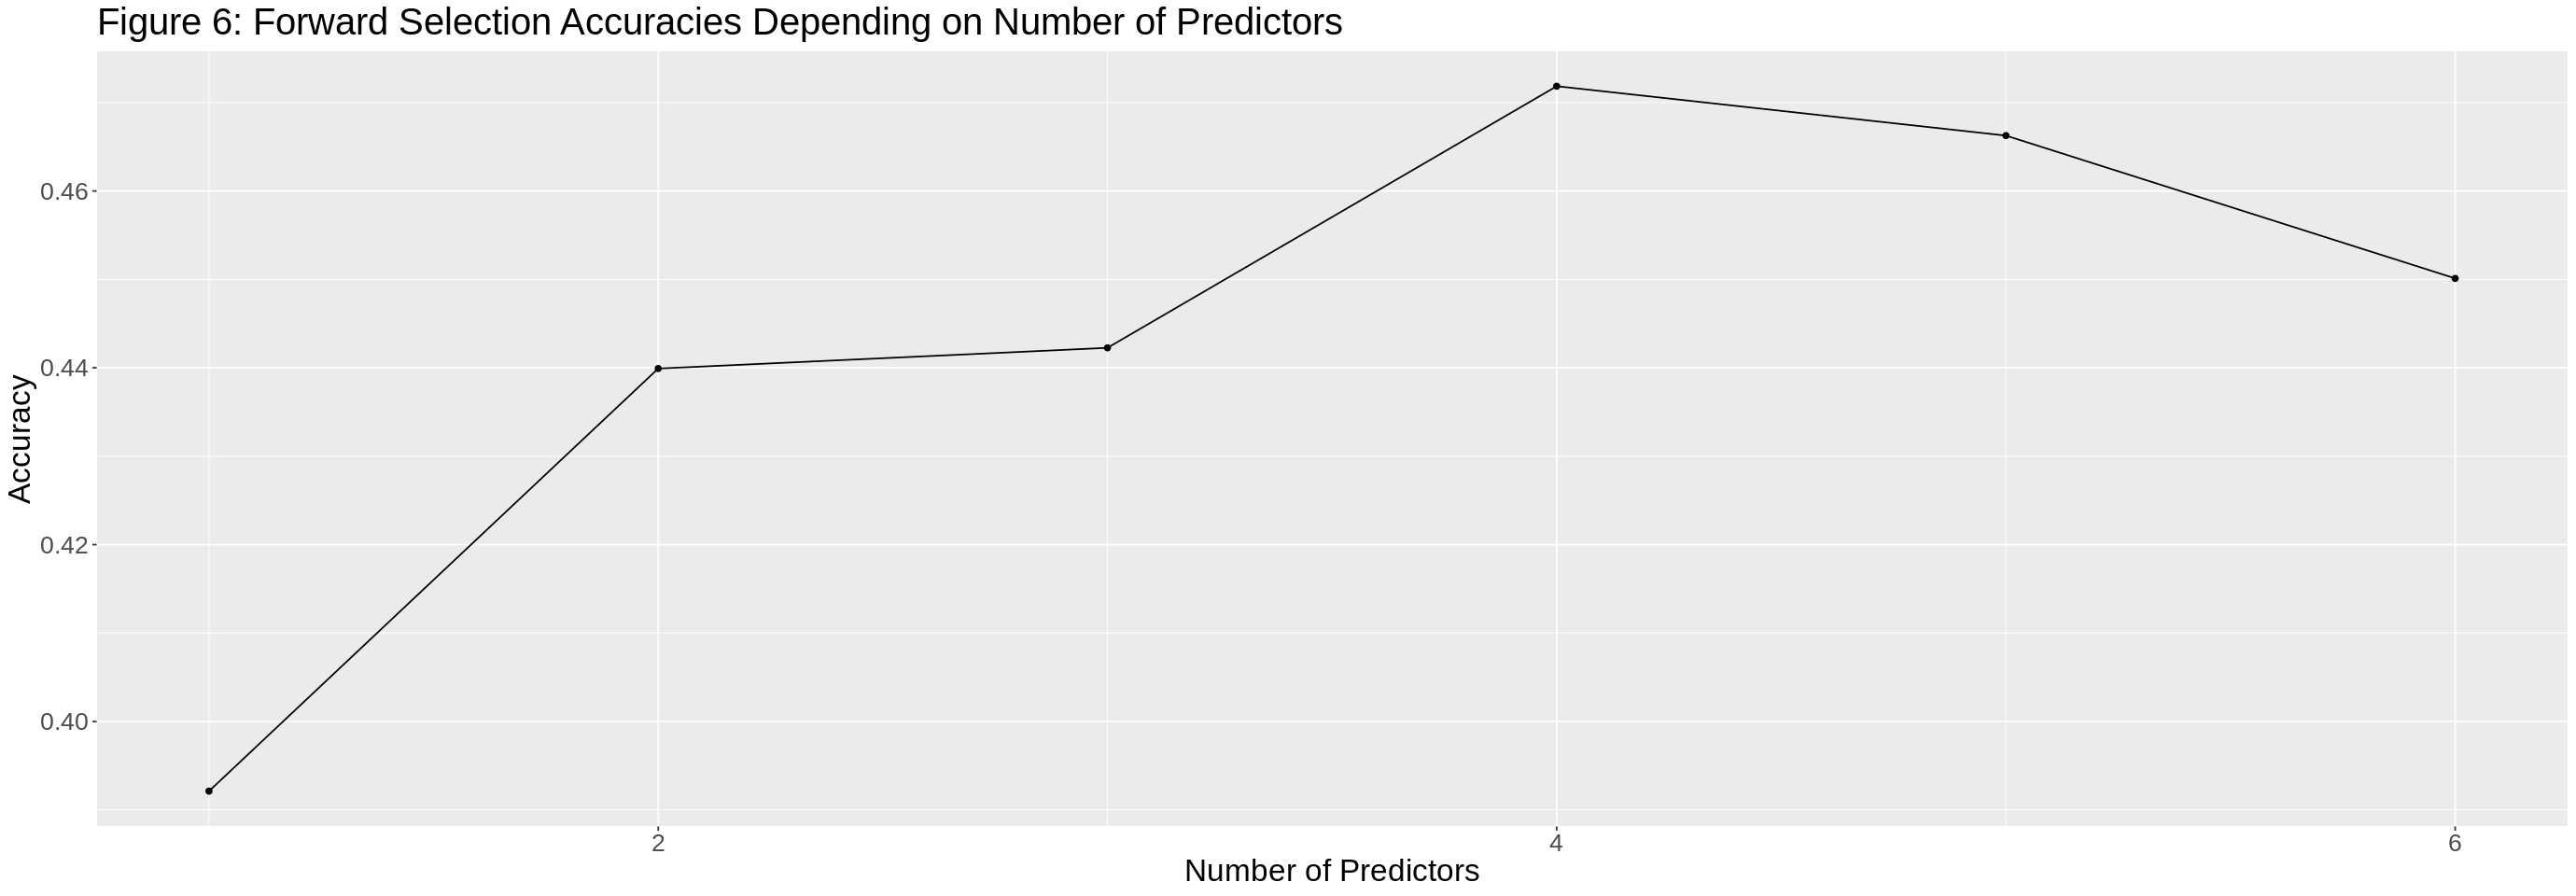

In [14]:
options(repr.plot.width = 23, repr.plot.height = 8)

fs_plot <- accuracies |> 
ggplot(aes(x = size, y = accuracy)) + 
geom_point() + 
geom_line() + 
labs(x = "Number of Predictors", y = "Accuracy") +
ggtitle ("Figure 6: Forward Selection Accuracies Depending on Number of Predictors") +
theme(text = element_text(size = 20))

fs_plot

Forward selection suggests that the predictors that maximize the level of accuracy are trestbps, slope, chol, thalach. Due to these findings, we dropped age and oldpeak as predictors and replaced them with slope. Later in the discussion, we explain how these predictors correlate with heart disease. 

## <b>Data Analysis<b>

### Cross Validation and Tuning 

Our recipe uses class as the target variable and maximum heart rate, serum cholesterol, resting heart rate and slope of peak exercise as the predictor variables. We scaled and balanced the predictors to ensure that our data is balanced and ideal for our analysis. We then specified our model as k-nn classification, set neighbors to tune and tested multiple values of k (from 1 to 20). Instead of testing every value from 1 to 20, we tested every second value. This ensured that the selection process was less time-consuming while allowng us to establish a general trend.  

To find the k-value that ensures the highest possible accuracy level for our model, we used five-fold cross-validation. This process randomly split the data into five evenly sized subunits where one is used for validation, while the remaining four are used as training sets. This process is repeated five times to obtain the accuracy of each specified k-value. These estimated accuracy values are then compared to one another to select the k that obtains the highest level of accuracy. 


In [15]:
set.seed(9876)

#Creating 5 folds for cross validations
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = class)

#Creating the recipe and performing centering, scaling and upsampling. 

heart_disease_recipe <- recipe(class ~ thalach + chol + trestbps + slope, data = heart_disease_train) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors())

#Creating the model specification for our knn classification model

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
        
#Creating a data frame for k values 
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 2))
heart_disease_recipe 
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Centering for all_predictors()
Scaling for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


To find the best k-value, we created a workflow that includes the recipe, model specification, tuning, and the collection of metrics. We then filtered the data to find the accuracy value of each k. Additionally, we also created a visualisation that plots all of the accuracy estimates for each k-value to add a sense of simplicity in selecting the best k.


In [16]:
set.seed(9876)

# Calculating the cross validation accuracy for all k values 
knn_results <- workflow() |>
               add_recipe(heart_disease_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = heart_disease_vfold, grid = k_vals)|>
               collect_metrics() |>
               filter(.metric == "accuracy")
knn_results        

print("Table 7: Validation Accuracy for All Specified k-values")

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3441717,5,0.01155808,Preprocessor1_Model01
3,accuracy,multiclass,0.3869259,5,0.02015220,Preprocessor1_Model02
5,accuracy,multiclass,0.3976656,5,0.01722481,Preprocessor1_Model03
7,accuracy,multiclass,0.4217424,5,0.01388629,Preprocessor1_Model04
9,accuracy,multiclass,0.4377482,5,0.01630791,Preprocessor1_Model05
11,accuracy,multiclass,0.4403057,5,0.01114784,Preprocessor1_Model06
13,accuracy,multiclass,0.4535007,5,0.01278121,Preprocessor1_Model07
15,accuracy,multiclass,0.4664423,5,0.01731443,Preprocessor1_Model08
17,accuracy,multiclass,0.4479842,5,0.01292645,Preprocessor1_Model09


[1] "Table 7: Validation Accuracy for All Specified k-values"


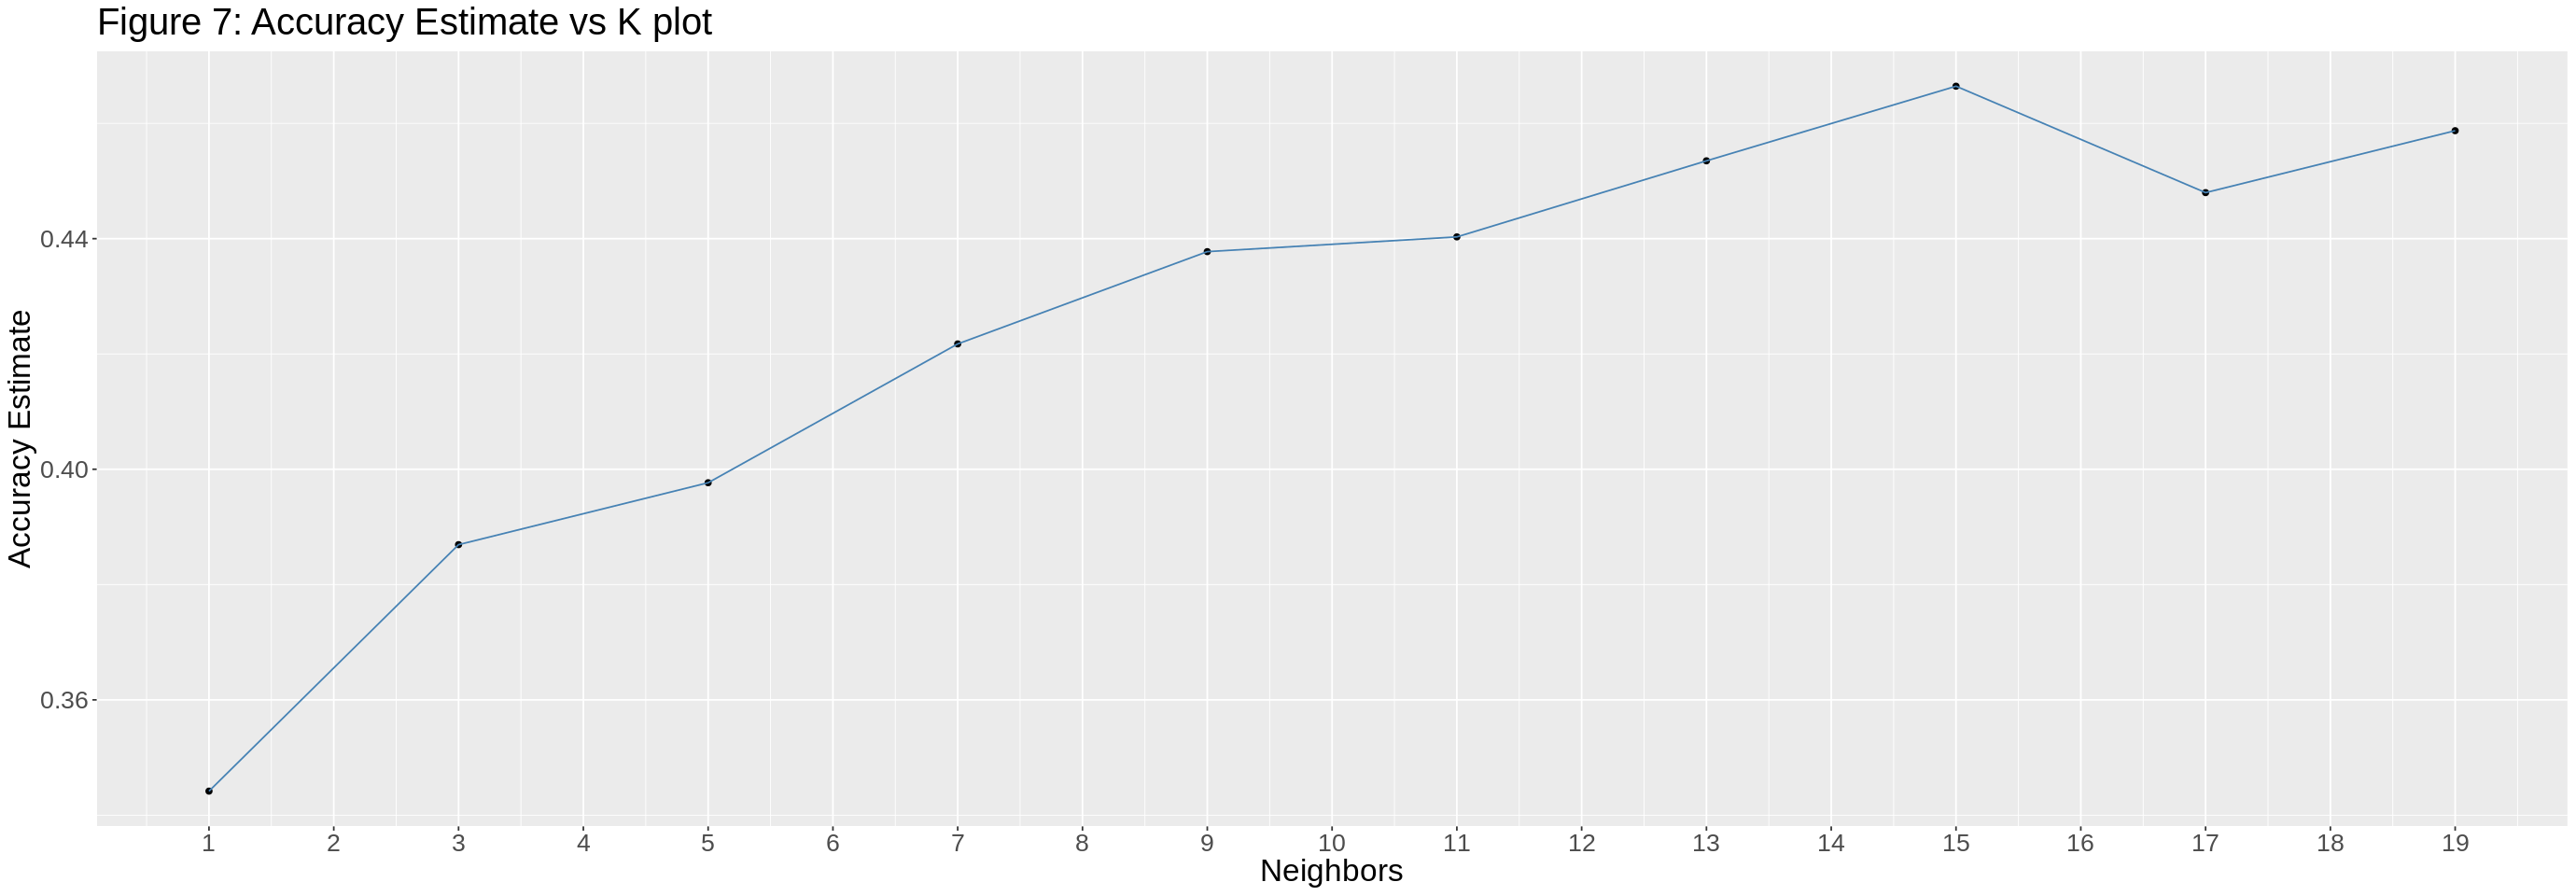

In [17]:
#Visualising the results using an accuracy estimate vs k plot 
options(repr.plot.width = 23, repr.plot.height = 8)

accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line(color = "steelblue") +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Figure 7: Accuracy Estimate vs K plot") +
  scale_x_continuous(breaks = 1:20) +
  theme(text = element_text(size = 20))
accuracy_vs_k 

In [25]:
#Pulling the best k-value
best_k <- knn_results |>
          filter(mean == max(mean)) |>
          pull(neighbors)

The accuracy vs k plot(Figure 7) suggests that the best k to use in the model is 15 as this is where the accuracy peaks.

### Creating the final model

We can now create the final model using the best k value that we found and determine its final level of accuracy.

In [19]:
set.seed(2451)

#Retraining the model with best k 
knn_spec_best <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#Creating the workflow and fitting the model to the training dataset
knn_fit <- workflow() |>
           add_recipe(heart_disease_recipe) |>
           add_model(knn_spec_best) |>
           fit(data = heart_disease_train)  

#making the predictions and 
heart_disease_predictions <- knn_fit |>
                             predict(heart_disease_test) |>
                             bind_cols(heart_disease_test)

#computing the accuracy of the classifier

accuracy <- heart_disease_predictions |>
            metrics(truth = class, estimate = .pred_class)|>
            filter(.metric == "accuracy") 
accuracy

print("Table 8: Accuracy Level of Final Model")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4173228


[1] "Table 8: Accuracy Level of Final Model"


### Visualisation of Results

In [20]:
print("Table 9: Confusion Matrix for Final k-nn Classification Model")
conf_mat( heart_disease_predictions, truth = class, estimate = .pred_class)

[1] "Table 9: Confusion Matrix for Final k-nn Classification Model"


          Truth
Prediction  0  1  2  3  4
         0 30  7  1  5  0
         1  7 10  8  5  3
         2  6  5  9  6  1
         3  4  8  3  4  3
         4  0  1  1  0  0

The confusion matrix shows that the classifier is great at correctly predicting class 0. On the other hand, it doesn't predict the class 4 correctly even once. We can say that the model is biased towards the majority class since there is more data of patients with no heart disease (class 0) than those with a severe level of heart disease (class 4).

We will now create a plot of the accuracy of predictions for each class. First we calculate the count of each class in the testing data set.

In [21]:
num_classes <- heart_disease_predictions |>
               group_by(class) |>
               summarize(total_predictions = n()) 

correct_predictions_by_class <- heart_disease_predictions |>
                                 select(.pred_class, class) |>
                                 filter(class == .pred_class) |>
                                 group_by(class) |>
                                 summarize(correct_predictions = n()) 
correct_predictions_by_class

print("Table 10: Correct Number of Predictions by Class")

class,correct_predictions
<fct>,<int>
0,30
1,10
2,9
3,4


[1] "Table 10: Correct Number of Predictions by Class"


Now we calculate the number of correct predictions for each class. <br>
It is important to note that Class 4 has a total of 0 correct predictions. We added a row to account for this.

In [22]:
correct_predictions_by_class <- add_row(correct_predictions_by_class, class = as.factor(4), correct_predictions = 0)

Now, we calculate the prediction accuracy for each class in the model

In [23]:
prediction_accuracy <-  num_classes |>
                        bind_cols(correct_predictions_by_class |> select(correct_predictions)) |>
                        mutate(accuracy =  correct_predictions/total_predictions)
prediction_accuracy                       
print("Table 11: Prediction Accuracy for Each Class")

class,total_predictions,correct_predictions,accuracy
<fct>,<int>,<dbl>,<dbl>
0,47,30,0.6382979
1,31,10,0.3225806
2,22,9,0.4090909
3,20,4,0.2000000
4,7,0,0.0000000


[1] "Table 11: Prediction Accuracy for Each Class"


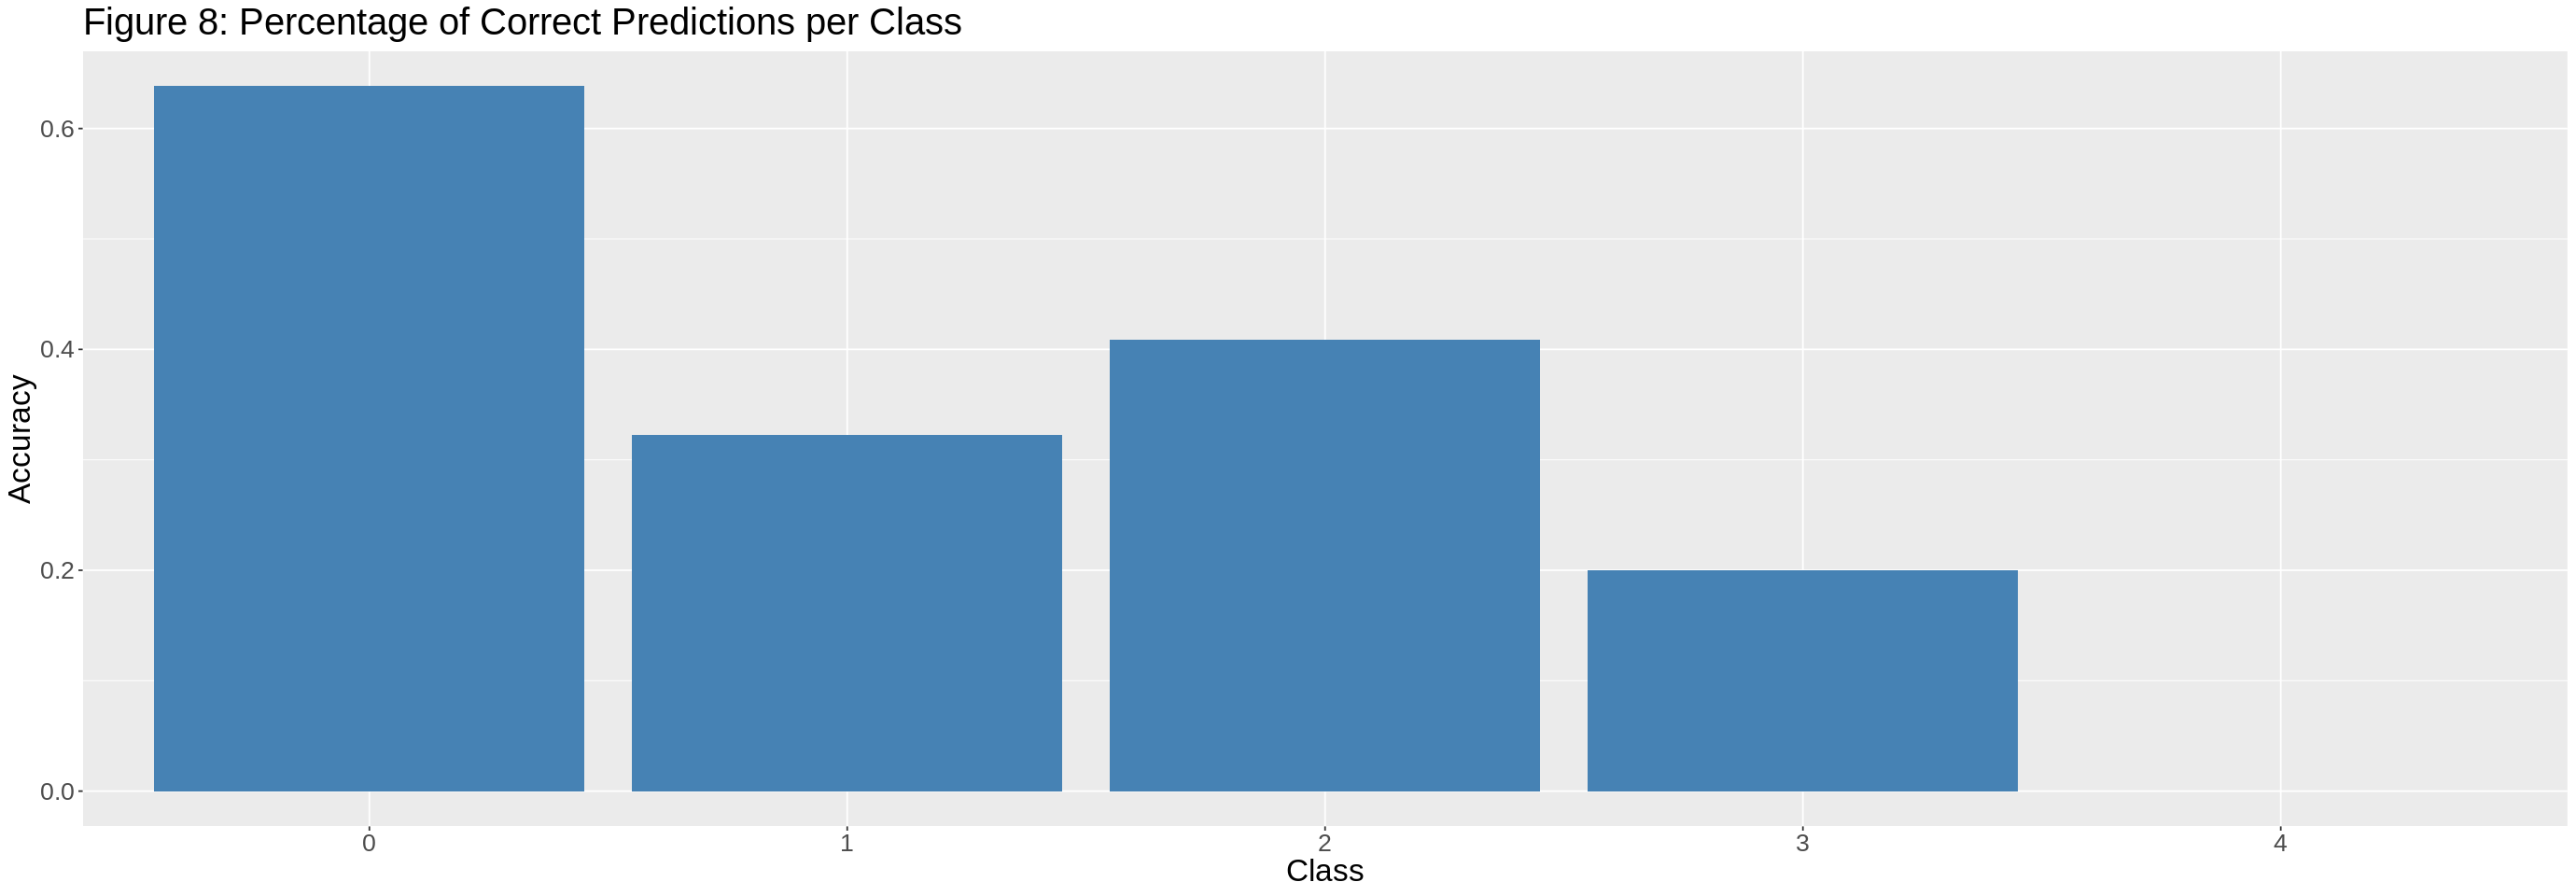

In [24]:
options(repr.plot.width = 23, repr.plot.height = 8)
accuracy_plot_classes <- ggplot(prediction_accuracy   , aes (x = class, y = accuracy)) + 
                         geom_bar(stat = "identity", fill = "steelblue") +
                         labs(x = "Class", y = "Accuracy") +
                         ggtitle ("Figure 8: Percentage of Correct Predictions per Class") + 
                         theme(text = element_text(size = 20)) 

accuracy_plot_classes

## <b>Discussion<b>

### Summary of Findings

### What we Expected to Find

### Impact of Findings

### Future Questions

## <b>References<b>